## **Twitter Sentiment Analysis**

In [1]:
import pandas as pd
import tensorflow as tf
import re
import os
import matplotlib.pyplot as plt
import numpy as np

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,Bidirectional
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print(tf.__version__)
!pip show distutils

2.17.0


### **Dataset Preview**

In [3]:
df_train = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_training.csv',header = None)

#berikan nama pada tiap header column
df_train.columns = ['tweet_id','product','sentiment','text']

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\INTEL\AppData\Local\Temp\ipykernel_29416\1885202653.py:1: SyntaxWarning: invalid escape sequence '\M'
  df_train = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_training.csv',header = None)


In [4]:
df_test = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_validation.csv')

df_test.columns = ['tweet_id','product','sentiment','text']

df_test

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\INTEL\AppData\Local\Temp\ipykernel_29416\2026914374.py:1: SyntaxWarning: invalid escape sequence '\M'
  df_test = pd.read_csv('D:\My AI Project\Twitter Sentiment Analysis_NLP\Dataset\\twitter_validation.csv')


,tweet_id,product,sentiment,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [5]:
#Cek data kosong
print(df_train.info())
print('-----------------------')
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   74682 non-null  int64 
 1   product    74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   999 non-null    int64 
 1   product    999 non-null    object
 2   sentiment  999 non-null    object
 3   text       999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB
None


In [6]:
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

In [7]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   74682 non-null  int64 
 1   product    74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       74682 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   999 non-null    int64 
 1   product    999 non-null    object
 2   sentiment  999 non-null    object
 3   text       999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB
None


In [8]:
#cek apakah ada data kosong pada tiap row
print(df_train.isna().sum())
print(df_test.isna().sum())


tweet_id     0
product      0
sentiment    0
text         0
dtype: int64
tweet_id     0
product      0
sentiment    0
text         0
dtype: int64


In [9]:
#cek distribusi total produk berdasarkan komentar
product_counts = df_train['product'].value_counts()
print(product_counts)

product
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)       

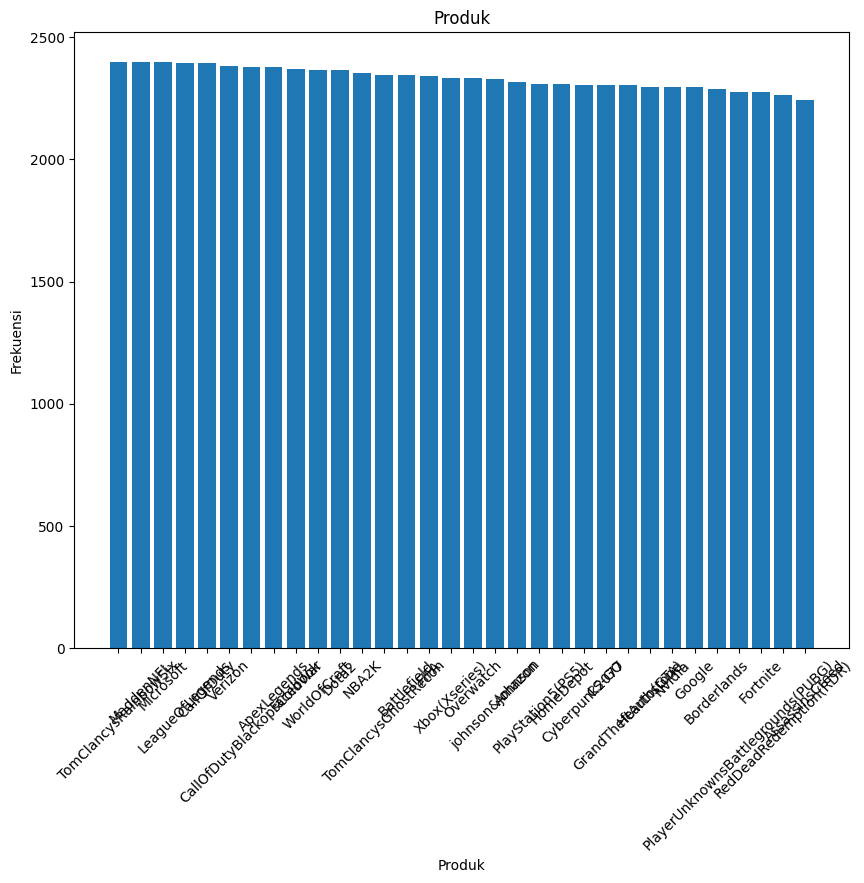

In [10]:
#Buat visualisasi
plt.figure(figsize=(10,8))
plt.bar(product_counts.index, product_counts.values)
plt.title("Produk")
plt.xlabel("Produk")
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()

## **Data Preprocessing**

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\INTEL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\INTEL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\INTEL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\INTEL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
from nltk.stem import WordNetLemmatizer

In [13]:
#Definisikan WordnetLemmatizer
lm = WordNetLemmatizer()

def preprocess_text(data):
    #definisikan array
    corpus = []

    stop_words = set(stopwords.words('english'))

    #iterasi tiap kata, potong, dan hilangkan kata2 yang mengandung unsur website
    for i in range(len(data)):
    #pertahankan kata2, hilangkan karakter, emot, dan unsur2 yang mengandung URL
        tweet = re.sub('[^a-zA-z]',' ',data[i])
    #kecilkan huruf
        tweet = tweet.lower()
    #split semua kalimat menjadi kata
        tweet = tweet.split()
    #stemming
        tweet = [lm.lemmatize(word) for word in tweet if not word in stop_words]
    #gabungkan kembali kata-katanya
        tweet = ' '.join(tweet)
    #kumpulkan ke dalam tweet
        corpus.append(tweet)

    return corpus

In [14]:
df_train.head(10)

,tweet_id,product,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [15]:
X_TRAIN = preprocess_text(df_train['text'])
X_TRAIN

['im getting borderland murder',
 'coming border kill',
 'im getting borderland kill',
 'im coming borderland murder',
 'im getting borderland murder',
 'im getting borderland murder',
 'spent hour making something fun know huge borderland fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent couple hour something fun know huge borderland fan maya one favorite character decided make wallpaper pc original picture compared creation made fun pic twitter com mlsi wf jg',
 'spent hour something fun know huge borderland fan maya one favorite character',
 'spent hour making something fun know huge rhandlerr fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg',
 'spent hour making something fun know huge rhandlerr fan maya one favorite character decided make wallpaper pc original image versus creation made enjoy pic twitter com mlsi wf jg

Lakukan hal yang sama untuk data uji

In [16]:
X_TEST = preprocess_text(df_test['text'])

### **Preprocessing 1: Bag of Words**

The “Bag of Words” technique will be used to embed the cleaned sentence data. To embed numbers in the words data, a CountVectorizer is used. The CountVectorizer is useful for taking certain unique words based on the number of frequencies and then assigning a unique number value to each word. 

Each word in the sentence is embedded with these numbers and the numbers are collected into 1 vector.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
#Definisikan CountVectorizer, ambil semua kata unik yang paling sering muncul dari data
cv = CountVectorizer(max_features = 150, ngram_range = (1,2))

#Lakukan penyematan angka pada kata, dan pembuatan vektor pada kalimat.
X_TRAIN = cv.fit_transform(X_TRAIN).toarray()

#Setting untuk cetak matriks
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

X_TRAIN

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0

Lakukan hal yang sama untuk data test

In [19]:
X_TEST = cv.fit_transform(df_test['text']).toarray()

X_TEST
X_TEST.shape

(999, 150)

In [20]:
cv.vocabulary_

{'amazon': 4,
 'like': 72,
 'co': 21,
 'microsoft': 76,
 'why': 140,
 'do': 27,
 'for': 33,
 'when': 138,
 'it': 63,
 'so': 108,
 'on': 88,
 'my': 80,
 'is': 62,
 'of': 86,
 'game': 38,
 'now': 84,
 'the': 115,
 'in': 60,
 'that': 114,
 'he': 53,
 'really': 102,
 'an': 5,
 'from': 36,
 'google': 45,
 'com': 22,
 '2020': 0,
 'in the': 61,
 'had': 50,
 'and': 6,
 'just': 67,
 'was': 135,
 'up': 129,
 'some': 109,
 'fifa': 31,
 'to': 123,
 'but': 17,
 'can': 20,
 'you': 148,
 'me': 75,
 'for the': 34,
 'new': 81,
 'pic': 96,
 'twitter': 127,
 'pic twitter': 97,
 'twitter com': 128,
 'league': 69,
 'or': 91,
 'love': 73,
 'playing': 99,
 'all': 3,
 'stream': 111,
 'best': 15,
 'twitch': 125,
 'still': 110,
 'creed': 23,
 'with': 142,
 'no': 82,
 'out': 93,
 'what': 137,
 'world': 144,
 'going': 43,
 'here': 55,
 'fucking': 37,
 'get': 40,
 'verizon': 131,
 'tv': 124,
 'twitch tv': 126,
 'by': 18,
 'team': 112,
 'nvidia': 85,
 'see': 106,
 'as': 8,
 'over': 94,
 'life': 71,
 'red': 103,
 'd

### **Label Encoding**

In [21]:
#Pertama-tama, lihat dulu ada berapa jumlah kelas data untuk target
df_train['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [22]:
#Ubah menjadi angka
Y_TRAIN = df_train['sentiment']
Y_TEST = df_test['sentiment']

#Ubah menjadi angka label
lb = LabelEncoder()
Y_TRAIN = lb.fit_transform(Y_TRAIN)
Y_TEST = lb.fit_transform(Y_TEST)


In [23]:
Y_TEST_mapping = dict(zip(lb.classes_, lb.fit_transform(Y_TEST)))
print(Y_TEST_mapping)

Y_TRAIN_mapping = dict(zip(lb.classes_, lb.fit_transform(Y_TRAIN)))
print(Y_TRAIN_mapping)

{'Irrelevant': 2, 'Negative': 1, 'Neutral': 1, 'Positive': 2}
{0: 3, 1: 3, 2: 3, 3: 3}


### **Deep Learning Model**


In [24]:
#Penyusunan model Deep Learning
custom_model = tf.keras.Sequential()
custom_model.add(Embedding(input_dim = X_TRAIN.shape[0], output_dim = 128, input_length = X_TRAIN.shape[1]))
custom_model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu'))
custom_model.add(MaxPooling1D(pool_size = 2))
custom_model.add(Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout=0.2)))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(16, activation='relu'))
custom_model.add(Dense(4, activation='softmax'))

#Compiling Model
custom_model.compile(optimizer = 'adam',
loss = 'sparse_categorical_crossentropy',
metrics = ['accuracy'])


c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
#Buat summary
model_summary = custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### **Model Training**

In [26]:
tf.keras.backend.clear_session()

In [27]:
#define earlystopping
from tensorflow.keras.callbacks import EarlyStopping

#Define earlystopping
#earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
#earlystopping

#fit and train model
history = custom_model.fit(X_TRAIN, Y_TRAIN,
validation_data = (X_TEST, Y_TEST),
epochs = 30,
batch_size = 64)
#callbacks = [earlystopping])

#scoring
score, acc = custom_model.evaluate(X_TEST, Y_TEST, verbose = 0)
print(f'Test Score: {score}')
print(f'Test Accuracy: {acc}')



Epoch 1/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 130s 108ms/step - accuracy: 0.3130 - loss: 1.3581 - val_accuracy: 0.3223 - val_loss: 1.3832
Epoch 2/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 155s 119ms/step - accuracy: 0.3890 - loss: 1.3027 - val_accuracy: 0.3113 - val_loss: 1.4060
Epoch 3/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 149s 125ms/step - accuracy: 0.4007 - loss: 1.2865 - val_accuracy: 0.3083 - val_loss: 1.4261
Epoch 4/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 130s 111ms/step - accuracy: 0.4063 - loss: 1.2762 - val_accuracy: 0.3143 - val_loss: 1.4304
Epoch 5/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 130s 112ms/step - accuracy: 0.4089 - loss: 1.2698 - val_accuracy: 0.2923 - val_loss: 1.4699
Epoch 6/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 128s 110ms/step - accuracy: 0.4138 - loss: 1.2638 - val_accuracy: 0.3263 - val_loss: 1.4470
Epoch 7/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 131s 113ms/step - accuracy: 0.4174 - loss: 1.2583 - val_accuracy: 0.3133 - val_loss: 1.4569
Epoch 8/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 134s 115ms/step - ac

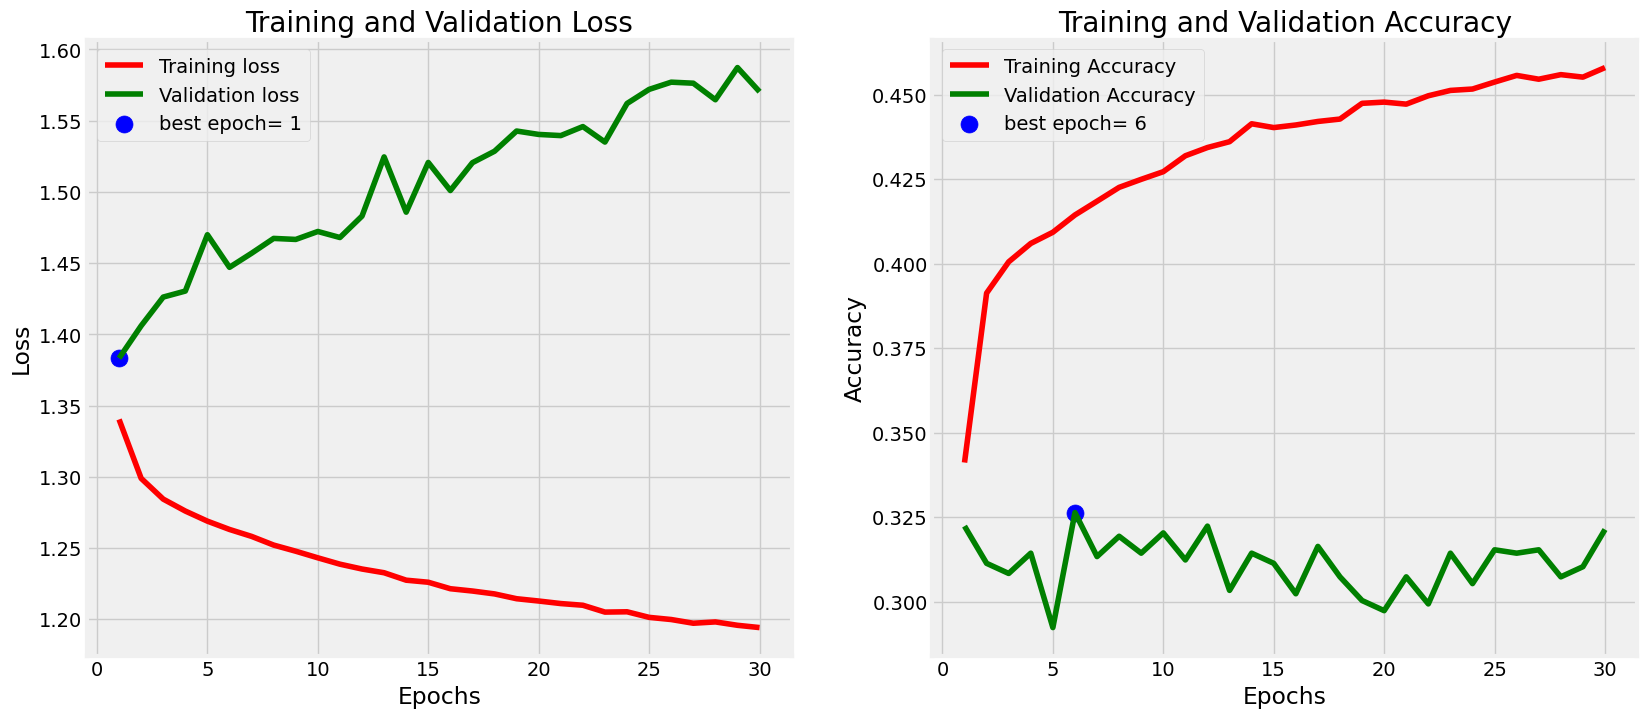

In [28]:
#Buat grafik utk keeping track
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [32]:
from sklearn.metrics import classification_report,f1_score

y_pred = np.argmax(custom_model.predict(X_TEST),axis = 1)
y_true = Y_TEST
accuracy_report = classification_report(y_pred,y_true)
f1_score_bow = f1_score(y_true, y_pred,average='macro')
print(accuracy_report)
print(f1_score_bow)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.11      0.29      0.15        63
           1       0.28      0.33      0.30       227
           2       0.31      0.36      0.33       244
           3       0.51      0.31      0.38       465

    accuracy                           0.32       999
   macro avg       0.30      0.32      0.29       999
weighted avg       0.38      0.32      0.34       999

0.2914302037556002


### **Preprocessing 2 : TF-IDF Vectorizer**

In [33]:
#import sklearn.feature_extraction.text.TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
#Lakukan proses encoding data dengan TF-IDF Vectorizer dan juga pembuatan Ngrams
tf_idf = TfidfVectorizer(max_features = 150, binary = True, ngram_range = (1,2))

#Ulangi pembersihan data kalinat
X_TRAIN = preprocess_text(df_train['text'])
X_TEST = preprocess_text(df_test['text'])


#Lakukan pembuatan vektor TF-IDF
X_TRAIN = tf_idf.fit_transform(X_TRAIN).toarray()
X_TEST = tf_idf.fit_transform(X_TEST).toarray()

X_TRAIN

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.694, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.694, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.694, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0

In [36]:
#fit and train
custom_model.fit(X_TRAIN,Y_TRAIN,
validation_data = (X_TEST, Y_TEST),
epochs = 30,
batch_size = 64)

#scoring
score, acc = custom_model.evaluate(X_TEST, Y_TEST, verbose = 0)
print(f'Test Score: {score}')
print(f'Test Accuracy: {acc}')

Epoch 1/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 135s 114ms/step - accuracy: 0.3087 - loss: 1.3590 - val_accuracy: 0.2663 - val_loss: 1.3704
Epoch 2/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 131s 112ms/step - accuracy: 0.3138 - loss: 1.3559 - val_accuracy: 0.2653 - val_loss: 1.3707
Epoch 3/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 140s 120ms/step - accuracy: 0.3145 - loss: 1.3544 - val_accuracy: 0.2683 - val_loss: 1.3715
Epoch 4/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 154s 132ms/step - accuracy: 0.3193 - loss: 1.3515 - val_accuracy: 0.2693 - val_loss: 1.3706
Epoch 5/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 282s 200ms/step - accuracy: 0.3146 - loss: 1.3528 - val_accuracy: 0.2723 - val_loss: 1.3731
Epoch 6/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 222s 190ms/step - accuracy: 0.3180 - loss: 1.3519 - val_accuracy: 0.2713 - val_loss: 1.3695
Epoch 7/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 259s 222ms/step - accuracy: 0.3197 - loss: 1.3512 - val_accuracy: 0.2683 - val_loss: 1.3705
Epoch 8/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 276s 236ms/step - ac

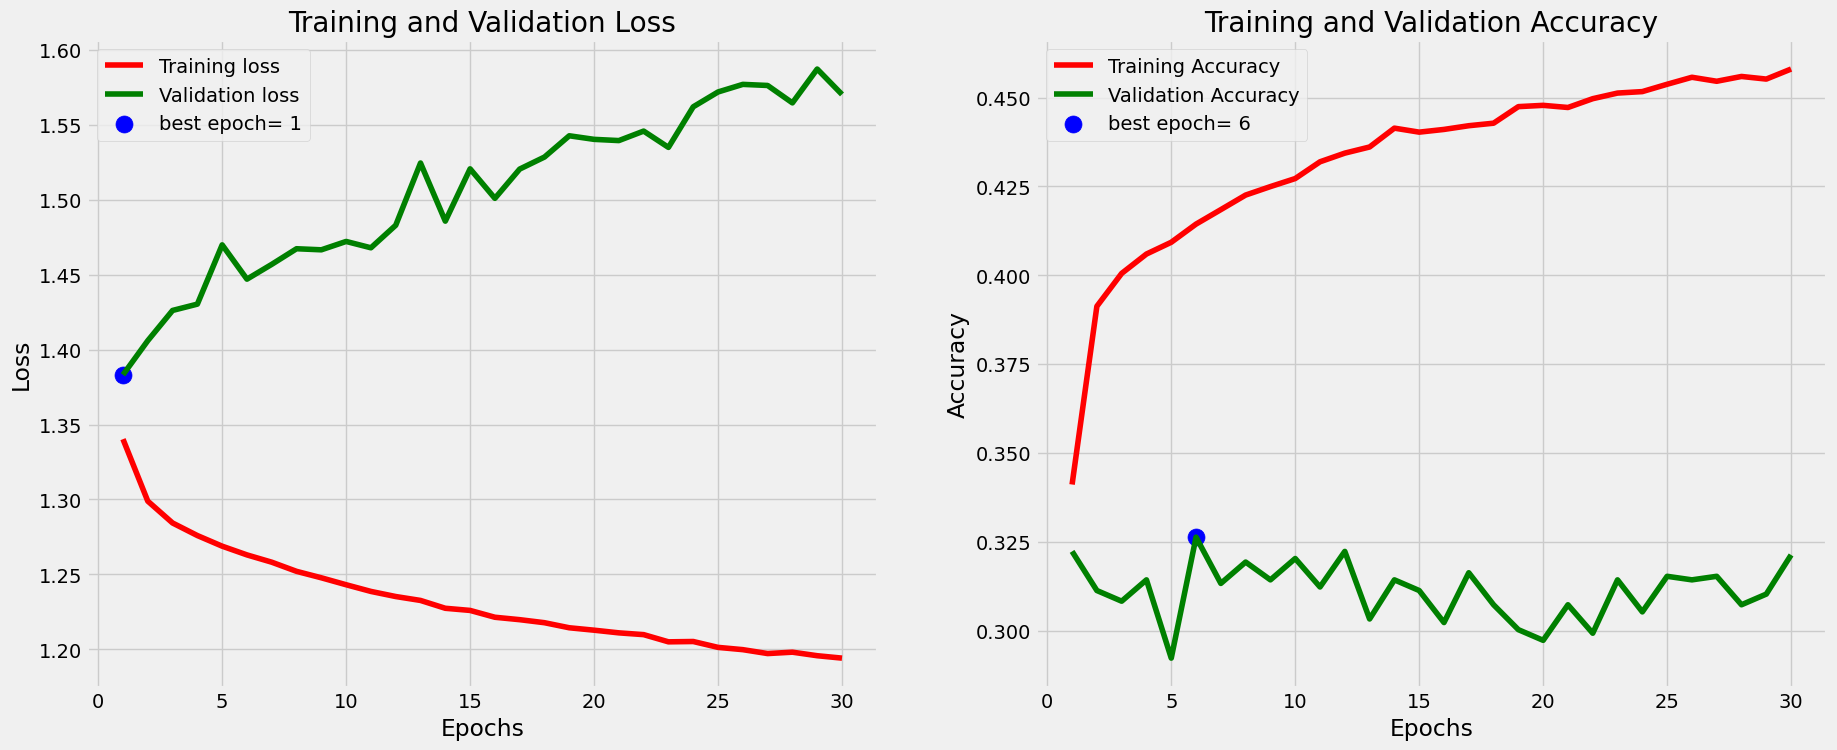

In [37]:
#visualize the accuracy and loss
#Buat grafik utk keeping track
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [38]:
y_pred = custom_model.predict(X_TEST)
y_pred = np.argmax(y_pred, axis = 1)
y_true = Y_TEST
#check f1 score
f1_score_tfidf = f1_score(y_true, y_pred,average='macro')
calculate_classification = classification_report(y_true, y_pred)
print(calculate_classification)
print(f1_score_tfidf)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.12      0.01      0.01       171
           1       0.27      0.95      0.41       266
           2       0.14      0.01      0.01       285
           3       0.46      0.05      0.09       277

    accuracy                           0.27       999
   macro avg       0.25      0.25      0.13       999
weighted avg       0.26      0.27      0.14       999

0.1311529568082764


### **Integer Encoding**

In [39]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences

#define the vocab size
vocab_size = 500
#preprocess the data
X_TRAIN = [one_hot(word,vocab_size) for word in df_train['text']]
X_TEST = [one_hot(word,vocab_size) for word in df_test['text']]
X_TRAIN


[[133, 459, 336, 308, 246, 141, 219, 373, 312, 116],
 [141, 18, 166, 186, 242, 258, 246, 141, 219, 423, 312, 116],
 [133, 459, 336, 308, 246, 141, 219, 423, 312, 116],
 [133, 166, 336, 308, 246, 141, 219, 373, 312, 116],
 [133, 459, 336, 308, 54, 246, 141, 219, 373, 312, 467, 116],
 [133, 459, 99, 308, 246, 141, 343, 373, 312, 116],
 [127,
  141,
  205,
  434,
  88,
  10,
  355,
  2,
  441,
  7,
  182,
  312,
  352,
  135,
  141,
  18,
  434,
  480,
  308,
  274,
  246,
  170,
  151,
  173,
  410,
  483,
  8,
  456,
  127,
  141,
  112,
  186,
  15,
  257,
  434,
  168,
  441,
  483,
  146,
  95,
  151,
  242,
  318,
  350,
  497,
  242,
  155,
  141,
  120,
  79,
  211,
  345,
  473,
  421],
 [127,
  141,
  205,
  434,
  470,
  410,
  10,
  302,
  2,
  441,
  7,
  182,
  312,
  352,
  135,
  454,
  253,
  434,
  480,
  308,
  274,
  246,
  170,
  151,
  173,
  410,
  483,
  8,
  456,
  141,
  112,
  186,
  15,
  434,
  168,
  441,
  483,
  146,
  24,
  242,
  318,
  290,
  363,
  186,

In [40]:
#pad sequence
X_TRAIN = pad_sequences(X_TRAIN, maxlen = 100,padding = 'post', truncating = 'post')
X_TEST = pad_sequences(X_TEST, maxlen = 100, padding = 'post', truncating = 'post')
X_TRAIN

array([[133, 459, 336, 308, 246, 141, 219, 373, 312, 116,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, ...,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [141,  18, 166, 186, 242, 258, 246, 141, 219, 423, 312, 116,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, ...,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [133, 459, 336, 308, 246, 141, 219, 423, 312, 116,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, ...,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [133, 166, 336, 308, 246, 141, 219, 373, 312, 116, 

In [41]:
#define earlystopping
from tensorflow.keras.callbacks import EarlyStopping

#Define earlystopping
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
earlystopping

#load the model, fit to the data, train the model
history = custom_model.fit(X_TRAIN,Y_TRAIN,
validation_data = (X_TEST,Y_TEST),
epochs = 30,
batch_size = 64,
callbacks = [earlystopping])

#scoring
score, acc = custom_model.evaluate(X_TEST, Y_TEST, verbose = 0)
print(f'Test Score: {score}')
print(f'Test Accuracy: {acc}')


Epoch 1/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 97s 82ms/step - accuracy: 0.2998 - loss: 1.3696 - val_accuracy: 0.3824 - val_loss: 1.3177
Epoch 2/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.3714 - loss: 1.3153 - val_accuracy: 0.4565 - val_loss: 1.2259
Epoch 3/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.4345 - loss: 1.2560 - val_accuracy: 0.5085 - val_loss: 1.1474
Epoch 4/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.4858 - loss: 1.1978 - val_accuracy: 0.5495 - val_loss: 1.0762
Epoch 5/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.5204 - loss: 1.1377 - val_accuracy: 0.5796 - val_loss: 1.0268
Epoch 6/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.5404 - loss: 1.1023 - val_accuracy: 0.5946 - val_loss: 0.9792
Epoch 7/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.5570 - loss: 1.0686 - val_accuracy: 0.6256 - val_loss: 0.9386
Epoch 8/30
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.5661 -

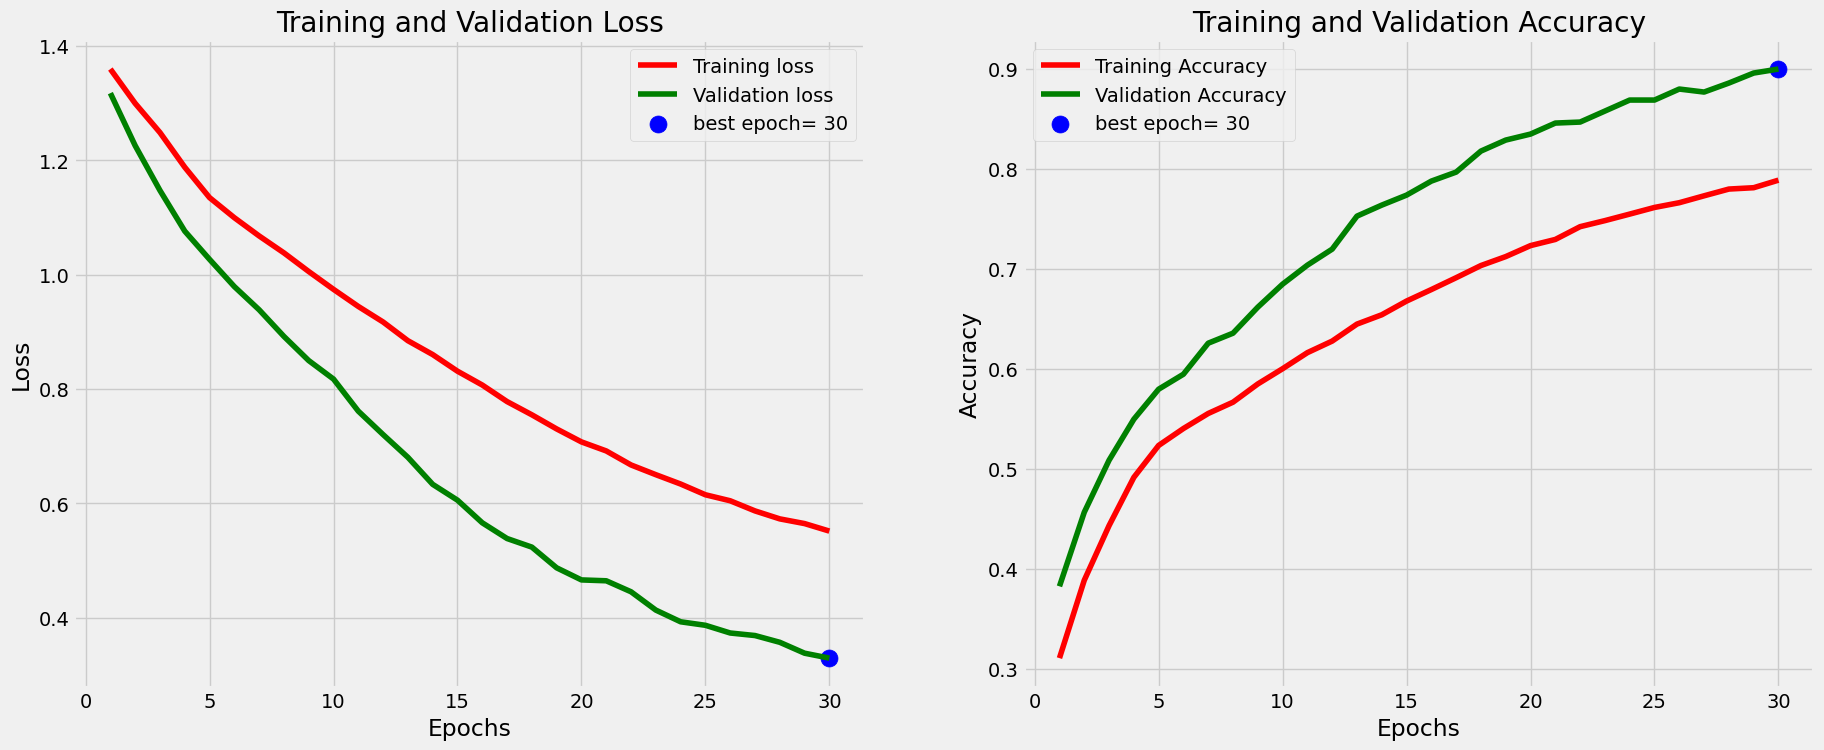

In [42]:
#Buat grafik utk keeping track
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [43]:
from sklearn.metrics import classification_report,f1_score

y_pred = custom_model.predict(X_TEST)
y_pred = np.argmax(y_pred, axis = 1)
y_true = Y_TEST
#check f1 score
f1_score_one_hot = f1_score(y_true, y_pred,average='macro')
calculate_classification = classification_report(y_true, y_pred)
print(calculate_classification)
print(f1_score_one_hot)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       171
           1       0.91      0.96      0.93       266
           2       0.90      0.90      0.90       285
           3       0.90      0.89      0.90       277

    accuracy                           0.90       999
   macro avg       0.90      0.89      0.90       999
weighted avg       0.90      0.90      0.90       999

0.8952210007124002


In [44]:
dict_compare = {
    'Y_TRUE' : y_true,
    'Y_PRED':y_pred}

df_compare_value = pd.DataFrame(dict_compare)
print(df_compare_value)

     Y_TRUE  Y_PRED
0         2       2
1         1       1
2         1       1
3         2       2
4         1       1
..      ...     ...
994       0       0
995       0       0
996       3       3
997       3       3
998       2       2

[999 rows x 2 columns]


### **Saving file for Deployment**

In [45]:
custom_model.save('lstm_model.h5')

### **Sentiment Analysis Using Pre-Trained Model : Google BERT**

Sebelum menggunakan model BERT dari Google, terlebih dahulu akan diimpor modul modul yang diperlukan untuk menjalankan model ini

In [46]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

### **Inisialisasi Model**

In [47]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [48]:
#lakukan analisis sentimen dengan membuat fungsi
dictio_sentiment_score = {
    1:'Negative',
    2:'Irrelevant',
    3:'Neutral',
    4:'Positive',
    5:'Positive'
}

#definisikan fungsi
def sentiment_scoring(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+ 1

In [49]:
df_train['sentiment_score'] = df_train['text'].apply(sentiment_scoring)
df_train

,tweet_id,product,sentiment,text,sentiment_score
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,5
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,5
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,5
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,5
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,5
...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,2
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,2
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,2
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,5


In [50]:
df_test['sentiment_score'] = df_test['text'].apply(sentiment_scoring)

In [51]:
#Buat Mapping Score dari BERT menjadi skor seperti yang ada di dataset
df_train['sentiment_predict'] = df_train['sentiment_score'].map(dictio_sentiment_score)
df_test['sentiment_predict'] = df_test['sentiment_score'].map(dictio_sentiment_score)

### **Comparing Results**

In [58]:
from sklearn.metrics import classification_report,f1_score

y_pred = df_test['sentiment_predict']
y_true = df_test['sentiment']
f1_score_BERT = f1_score(y_true,y_pred,average = 'macro')
classification_scoring = classification_report(y_pred, y_true)
print(classification_scoring)

              precision    recall  f1-score   support

  Irrelevant       0.04      0.18      0.07        39
    Negative       0.78      0.44      0.56       468
     Neutral       0.06      0.33      0.10        49
    Positive       0.73      0.46      0.56       443

    accuracy                           0.43       999
   macro avg       0.40      0.35      0.32       999
weighted avg       0.69      0.43      0.52       999



In [59]:
#f1_score for each preprocessing method

#Preprocessing Comparation
method_comparison_df = pd.DataFrame(
    {
        'method': ['Bag of Words','TF-IDF','Integer Encoding','BERT Encoder'],
        'f1_score': [f1_score_bow, f1_score_tfidf, f1_score_one_hot,f1_score_BERT]
    }
)

method_comparison_df

,method,f1_score
0,Bag of Words,0.291430
1,TF-IDF,0.131153
2,Integer Encoding,0.895221
3,BERT Encoder,0.321905


: 

### **Conclusion**

* To make deep learning models actually **"learns"** something from text data files, we need to extract information by using **encoding** or change text into vector/tensor of numbers. Here I use 3 types of data text encoding, **Bag of Words**, **TF-IDF Vectorizer**, and **One-Hot Encoding**.
* Based on **classification report**, **Bag of Words** and **TF-IDF Vectorizer** is very slow to gain convergence. In **30 epochs**, both of them only gain 0.42 on "Irrelevant" class F1-Score, while other classification is **0.0**
* Surprisingly, One Hot encoding is the fastest preprocessing method which gains convergence in 30 epochs. With **validation accuracy 92.6%**.
  All of F1-Score on one hot encoding preprocessig method gain **more than 90% score**. 
* Even one hot encoding preprocessing method still win if it compared with Google BERT. This can be happening because Google BERT is **general pre-trained model** which is trained with **general data**, not specific in Twitter Sentiment prediction.